# 1. Introduction

<t>Malaria is a parasitic disease which can affect humans with symptoms ranging from mild to severe; the most sever cases can even lead to death. Machine learning applications are being broadly implemented in the medical community to recognize and diagnose disease, as well as to determine appropriate methods of treatment. This project consists of a series of models which seek to identify cells which are infected with malaria. However, the primary purpose of this project is to show the potential for efficacy in models with less complexity which display a smaller computational cost. 
    
<t><p>The dataset used was provided by kaggle, and I referenced some pre-existing kernels to get an idea of what types of models I would build. The only work which was not created on my own, was to determine which optimizer and loss functions to use. The rest of my models were designed and implemented by myself. Tovio had described color histograms to me earlier in the semester and I decided to implement those ideas, but did so on my own without much help.

# 2. Libraries used

<t>Throughout the project I used a number of libraries; cv2 is an image processing library used to read in the images, to resize, and to change the way the images were represented in data. The os library was used for defining file paths and feeding the images to cv2. Numpy was used primarily for vectorized math functions. Sci-kit image was used to apply an edge detection filter to the images. From the sci-kit learn library I used some basic tools in preprocessing and data partitioning. Keras was used to build all of the neural networks, both naive and convolutional; the keras wrapper was used on a tensorflow backend. The datetime library was used to capture execution times of each model. 

In [1]:
# Imports
import cv2
import os
import numpy as np
from skimage.filters import prewitt
import sklearn.preprocessing as preproc
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D
from keras import optimizers
from datetime import datetime
import matplotlib.pyplot as plt


Using TensorFlow backend.


# 3. Reading in images
<br>
First, loading the images into their matrix representations was completed with cv2. There are two ways the images were read into matrices. The first was to convert the images to 128 x 128 pixels, and change the format to grayscale. The second method retained all three color levels; in efforts to minimize the number of dimensions these images were limited to each layer being 64 x 64 x 3 pixels. 

#### Set the filepath and create a list of folders to read in

In [2]:
dataset_path = "cell_images"

# Explore the file to see which directories it contains
class_folders = os.listdir(dataset_path)

In [38]:
data1 = []

# For all of the non-system folders, we build a list of the paths 
# that contain images
for image_class in class_folders:
    # Exclude system files which start with '.'
    if not image_class.startswith('.'):
        image_list = os.listdir('{}/{}'.format(dataset_path, 
                                        image_class))
        # Iterate through the images in each folder, read in the images
        for image_name in image_list:
            if not image_name.startswith('.'):
            
                # For each image in our folder, we first read the image,
                image = cv2.imread('{}/{}/{}'.format(dataset_path, 
                                          image_class, image_name))
                # Next, the image is formatted to 128 x 128
                image = cv2.resize(image, (128, 128), 
                               interpolation=cv2.INTER_NEAREST)
            
                # Next, format the image to Grayscale
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
                # Append the image to our list of data
                data1.append(image)

#### Read in the images as RGB in the shape of 64 x 64 x 3

In [39]:
data2 = []

# For all of the non-system folders, we build a list of the paths 
# that contain images
for image_class in class_folders:
    # Exclude system folders
    if not image_class.startswith('.'):
        image_list = os.listdir('{}/{}'.format(dataset_path, 
                                        image_class))
        
        # Iterate through each image in th folder
        for image_name in image_list:
            if not image_name.startswith('.'):
            
                # Read in the image
                image = cv2.imread('{}/{}/{}'.format(dataset_path, 
                                          image_class, image_name))
                # Next, the image is formatted to 64 x 64
                image = cv2.resize(image, (64, 64), 
                               interpolation=cv2.INTER_NEAREST)
            
                # Append the image to our list of data
                data2.append(image)

#### Check the shapes of an image from each type that has been read in

In [5]:
data1[0].shape

(128, 128)

In [6]:
data2[0].shape

(64, 64, 3)

# 4. Exploratory Visualizations

<t><p> The next step in model building was to take a look at some of the images. I looked at the greyscale, and the color images. After looking at the greyscale images, Tovio and I decided that edge detection might create an effective way at creating more clear signals in the data. Looking at the two types of greyscale images, it seems as if the edge detection would produce a histogram with features that are more easily categorized by a model. The color images also led me to beleive that a histogram approach could be effective, as there seemed to be a distinct color range on the images of the malaria infestations. These observations provided some insight as to how I wanted to approach the data; it seemed as if a color-histogram approach of the edge detected models could be succesful. In addition to this histogram approach I wanted to look at the performance of a 2d CNN on the raw image data. 

#### First, we have 12 images of cells that are malaria infected which have been converted to grayscale

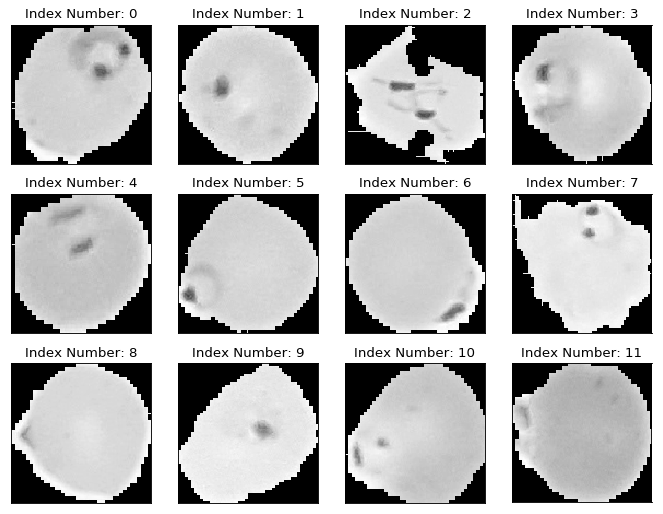

In [40]:
# Create the figure
plt.figure(num=None, figsize=(8, 6), 
           dpi=80, facecolor='w', edgecolor='k')

# Plot the first ten images
for i in np.arange(12):
    
    # Choose a sample
    sample=data1[i]
    
    # Reshape the sample
    sample=sample.reshape((128,128))
    
    # Define the subplot, title, and clear the ticks
    plt.subplot(3, 4, i+1)
    plt.title('Index Number: {}'.format(i))
    plt.imshow(sample,cmap='gray')
    plt.xticks([])
    plt.yticks([])

# Adjust the spacing inbetween the plots and show the subplots
plt.subplots_adjust(left=1, right=2, bottom=1, top=2)
plt.show()

# plt.imshow(prewitt(data1[0]), cmap = 'gray')

#### Next we visualized those same cells, after applying edge detection. 

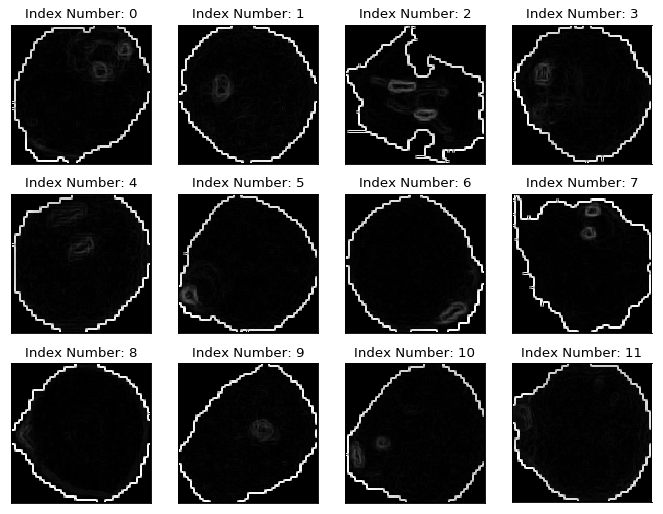

In [7]:
# Create the figure
plt.figure(num=None, figsize=(8, 6), 
           dpi=80, facecolor='w', edgecolor='k')

# Plot the first ten images
for i in np.arange(12):
    
    # Choose a sample
    sample=prewitt(data1[i])
    
    # Reshape the sample
    sample=sample.reshape((128,128))
    
    # Define the subplot, title, and clear the ticks
    plt.subplot(3, 4, i+1)
    plt.title('Index Number: {}'.format(i))
    plt.imshow(sample,cmap='gray')
    plt.xticks([])
    plt.yticks([])

# Adjust the spacing inbetween the plots and show the subplots
plt.subplots_adjust(left=1, right=2, bottom=1, top=2)
plt.show()

# plt.imshow(prewitt(data1[0]), cmap = 'gray')

#### Next we have 12 images of those same positive samples in the standard RGB format

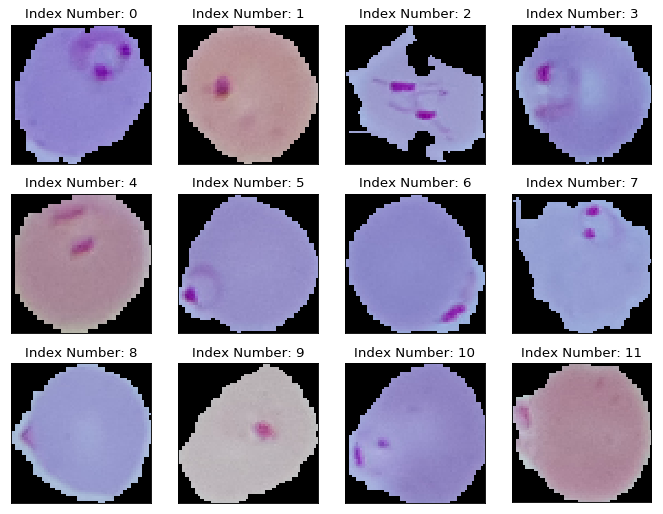

In [8]:
# Create the figure
plt.figure(num=None, figsize=(8, 6), 
           dpi=80, facecolor='w', edgecolor='k')

# Plot the first ten images
for i in np.arange(12):
    
    # Choose a sample
    sample=data2[i]
    
#     # Reshape the sample
#     sample=sample.reshape((28,28))
    
    # Define the subplot, title, and clear the ticks
    plt.subplot(3, 4, i+1)
    plt.title('Index Number: {}'.format(i))
    plt.imshow(sample)
    plt.xticks([])
    plt.yticks([])

# Adjust the spacing inbetween the plots and show the subplots
plt.subplots_adjust(left=1, right=2, bottom=1, top=2)
plt.show()

### Visualizations of negative samples

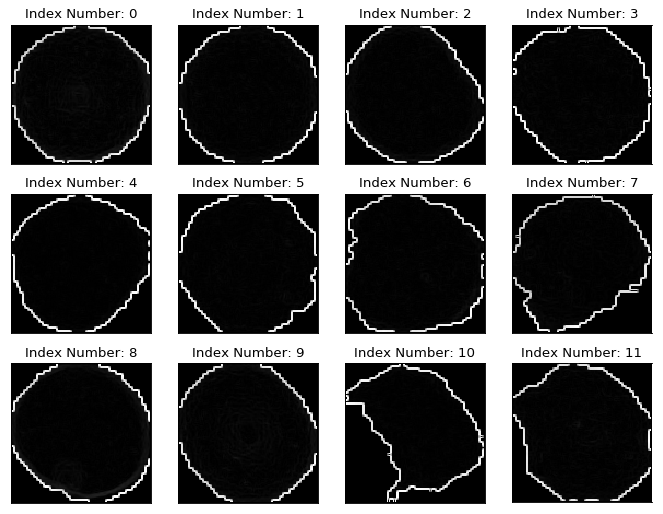

In [9]:
# Create the figure
plt.figure(num=None, figsize=(8, 6), 
           dpi=80, facecolor='w', edgecolor='k')

# Plot the first ten images
for i in np.arange(12):
    
    # Choose a sample
    sample=prewitt(data1[20000 + i])
    
    # Reshape the sample
    sample=sample.reshape((128,128))
    
    # Define the subplot, title, and clear the ticks
    plt.subplot(3, 4, i+1)
    plt.title('Index Number: {}'.format(i))
    plt.imshow(sample,cmap='gray')
    plt.xticks([])
    plt.yticks([])

# Adjust the spacing inbetween the plots and show the subplots
plt.subplots_adjust(left=1, right=2, bottom=1, top=2)
plt.show()

### Color visualizations of negative samples

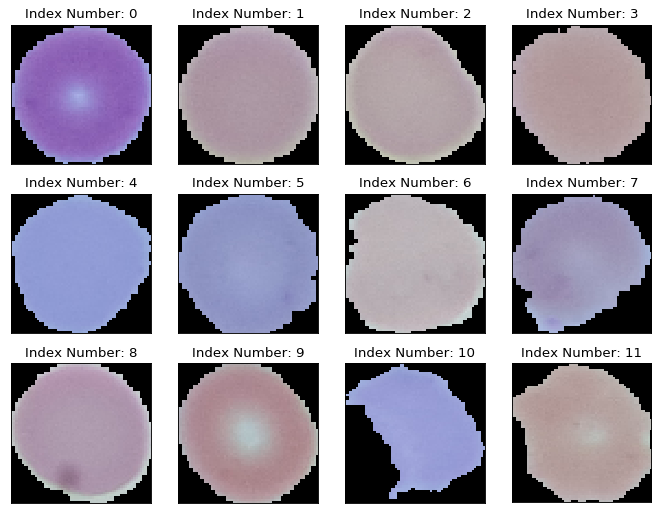

In [10]:
# Create the figure
plt.figure(num=None, figsize=(8, 6), 
           dpi=80, facecolor='w', edgecolor='k')

# Plot the first ten images
for i in np.arange(12):
    
    # Choose a sample
    sample=data2[20000 + i]
    
#     # Reshape the sample
#     sample=sample.reshape((28,28))
    
    # Define the subplot, title, and clear the ticks
    plt.subplot(3, 4, i+1)
    plt.title('Index Number: {}'.format(i))
    plt.imshow(sample,cmap='gray')
    plt.xticks([])
    plt.yticks([])

# Adjust the spacing inbetween the plots and show the subplots
plt.subplots_adjust(left=1, right=2, bottom=1, top=2)
plt.show()

### Make histograms for Greyscale images after line detection.

In [11]:
hists = []
edges = []

for image in data1:    
    image2 = prewitt(image)
    image3 = preproc.normalize(image2, axis=1, norm='max')
    image3 = image3 * 255
    image4 = image3.astype(int)
    hist = np.histogram(image4, bins = 256)
    edges.append(hist[0][1:255])

### Make histograms for each color layer and concatenate them so each sample is represented by a single row

In [44]:
# Declare empty lists to capture the incoming histograms
this = []
this1 = []
this2 = []

# Iterate through each image and create the histograms
for image in data2: 
    # Capture the histogram for the first color layer
    # ignoring the values at or near zero
    hist = cv2.calcHist([image], [0], None, [255], [1, 255])
    this.append(hist)
    
    # Capture the histogram for the second color layer
    # ignoring the values at or near zero
    hist1 = cv2.calcHist([image], [1], None, [255], [1, 255])
    this1.append(hist1)
    
    # Capture the histogram for the third color layer
    # ignoring the values at or near zero
    hist2 = cv2.calcHist([image], [2], None, [255], [1, 255])
    this2.append(hist2)

# Concatenate all three of the histograms by row
this3 = np.concatenate((this, this1, this2), axis = 1)

# Reshape the array to desired shape. We now have each row representing a sample
# of length 765 - the concatenated histogram length
this3 = this3.reshape(27558, 765)

# 5. Building the histograms
<br>
<t>Having decided on utilizing models which are built on looking at the color histograms of both the color and the greyscale images; the next task was to create histograms for each type. The greyscale histograms were quite simple, the most difficult part was after applying the edge detection the built-in tools in cv2 wouldn't work. To resolve the issue spent effort first on normalizing the data (the original values were very near zero), and then applying the histogram tool built into numpy. As all of the images were primarily black (matrix values of zero), I made the decision to exclude those lowest values from my histograms. I created a bin for each value above 2, ending up with 254 bins - each which represents an integer's worth of values. 
    
<t>Building the histograms for the color model were in some ways much more simple, in others way more complex. The cv2 tool worked effectively on the image layers, but it was necessary to concatenate the layers so I had a single row with all three histograms. In the end, numpy had several robust tools to accomplish this. 

### Let's look at some histograms. The first set is an infencted and uninfected greyscale histogram

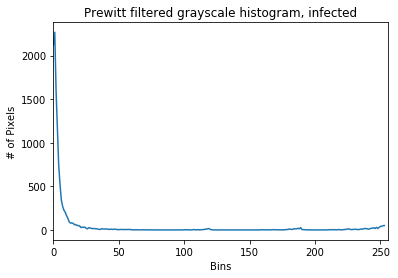

In [13]:
# Define the figure
plt.figure()

# Set the title and axis labels, define the x-axis range
plt.title("Prewitt filtered grayscale histogram, infected")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.xlim([0, 256])

# Plot the histogram distribution
plt.plot(edges[0])

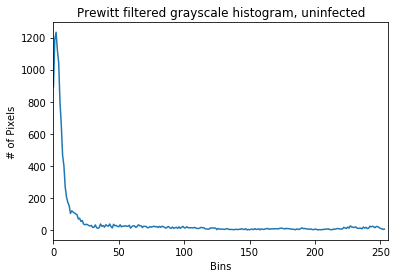

In [14]:
# Define the figure
plt.figure()

# Set the title and axis labels, define the x-axis range
plt.title("Prewitt filtered grayscale histogram, uninfected")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.xlim([0, 256])

# Plot the histogram distribution
plt.plot(edges[20000])

### Next, we have histograms of our color data. We can see three clear peaks, one for each color layer

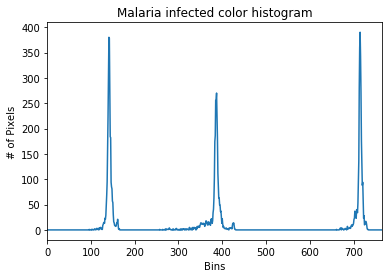

In [15]:
# Define the figure
plt.figure()

# Set the title, axis labels, and x-axis range
plt.title("Malaria infected color histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.xlim([0, 765])

# Plot the histogram distribution
plt.plot(this3[0])

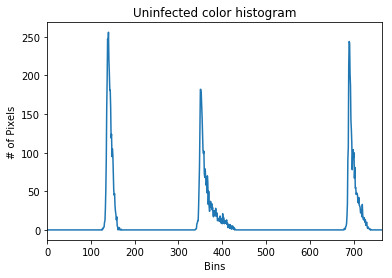

In [16]:
# Define the figure
plt.figure()

# Set the title, axis labels, and x-axis range
plt.title("Uninfected color histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.xlim([0, 765])

# Plot the histogram distribution
plt.plot(this3[20000])

# 6. Model building
<br>
 <t>On kaggle, the 2d CNN approach was by far the most common, and many models had very positive results. However, each of these models were relatively deep in the number of layers used and quite computationally expensive. For example, the most popular model had four convolutional layers combined with four fully connected layers; this model ended up producing accuracy in the range of 96%. However, there was not much finesse used in the creation of this model as it took approximately an hour and a half to run on my multi-core machine. This approach was the equivalent of simply throwing computational power at a problem and hoping for the best. I hypothesized that building a naive neural network which looked at each histogram bin as a feature, would likely be as effective while using far less computational resources. 
<br><br>
<t>In terms of model specifics, I chose to keep everything relatively simple. The 3-color histogram model is simply built with three layers; the first is a fully-connected layer with 256 nodes, the second is a fully-connected layer with 128 nodes. Both of these layers were followed by a relu activation node. I experimented with several models which were more complex, but any gains in performance were marginal at best. I also tried models with different activations at each level, primarily focusing on sigmoid vs. relu. To get this final  model to run effectively with the relu activations, it was important to tune the compilation parameters and normalize the data. This normalization step is almost always necessary to achieve the best results when implementing a model which utilizes relu activation. In general, I found the relu based models to function far better than the same model built on sigmoid. <br>
<br>
<t>The parameter settings on the compilation were fairly straight forward, I've had a lot of success in a wide variety of models using an Adam optimizer, as opposed to Stochastic Gradient Descent. Binary cross-entropy based models gave me the best results, which makes a lot of sense, being that I'm performing a binary classification. 

### This is a model to run the 3-color histogram data

In [47]:
# Define the model layers
model = Sequential([
    # Fully connected dense layer with 256 nodes, and relu activation
    Dense(256, input_shape=(765,)),
    Activation('relu'),
    
    # Fully connected dense layer with 128 nodes, and relu activation
    Dense(128, input_shape=(256,)),
    Activation('relu'),
    
    # Single node dense layer with sigmoid activation to create class label
    Dense(1, input_shape=(128,)),
    Activation('sigmoid')
])

# Compile the model using an Adam optimizer, binary cross-entropy loss, 
# and accuracy as the target metric
model.compile(optimizer=optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Create Labels

In [18]:
# Create labels for all models; 0 - Infected, 1 - Uninfected
labels = np.concatenate((np.repeat(0, 13779), np.repeat(1, 13779)))

### Split the data

In [45]:
# Normalize the data from 0 to 1 (originally 1-255)
this3 = this3 / 255

# Split the data into train/test
(train_X, test_X, train_Y, test_Y) = \
    train_test_split(this3, labels, test_size=.25, random_state = 99)

### Run and time the model 

In [48]:
# Start time
time_in = datetime.now()

# Run the model, append metrics to a variable for plotting
history = model.fit(train_X, train_Y, 
          validation_data=(test_X, test_Y), epochs=20, batch_size=32)

# End time
time_out = datetime.now()

Train on 20668 samples, validate on 6890 samples
Epoch 1/20
20668/20668 [==============================] - 2s 96us/step - loss: 0.6086 - acc: 0.6659 - val_loss: 0.5688 - val_acc: 0.7032
Epoch 2/20
20668/20668 [==============================] - 2s 74us/step - loss: 0.5265 - acc: 0.7443 - val_loss: 0.4914 - val_acc: 0.7675
Epoch 3/20
20668/20668 [==============================] - 2s 73us/step - loss: 0.4334 - acc: 0.8191 - val_loss: 0.3981 - val_acc: 0.8433
Epoch 4/20
20668/20668 [==============================] - 2s 74us/step - loss: 0.3398 - acc: 0.8793 - val_loss: 0.3210 - val_acc: 0.8948
Epoch 5/20
20668/20668 [==============================] - 2s 75us/step - loss: 0.2732 - acc: 0.9119 - val_loss: 0.2729 - val_acc: 0.9134
Epoch 6/20
20668/20668 [==============================] - 2s 75us/step - loss: 0.2319 - acc: 0.9293 - val_loss: 0.2451 - val_acc: 0.9253
Epoch 7/20
20668/20668 [==============================] - 2s 75us/step - loss: 0.2053 - acc: 0.9367 - val_loss: 0.2282 - val_acc:

### Plot the accuracy and loss, print the execution time

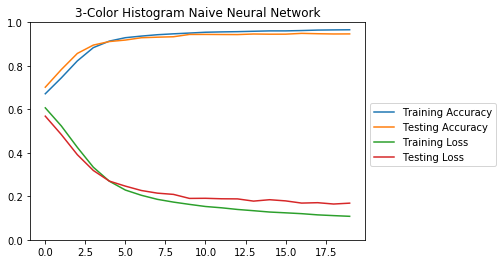

Elapsed Time:  0:00:32.200503


In [21]:
# Training accuracy
plt.plot(history.history['acc'], label='Training Accuracy')

# Testing accuracy
plt.plot(history.history['val_acc'], label='Testing Accuracy')

# Training loss
plt.plot(history.history['loss'], label='Training Loss') 
plt.plot(history.history['val_loss'], label='Testing Loss')

# Testing loss
plt.legend(bbox_to_anchor=(1, .65), loc='upper left', ncol=1)

# Set the title
plt.title('3-Color Histogram Naive Neural Network')

# Set the y-limit
plt.ylim(0,1)

# Display the plot
plt.show()

print("Elapsed Time: ", time_out - time_in)

### This model runs the greyscale histogram

<t>The model I chose to run the greyscale histograms ended up being slightly more complicated than the model for the color histogram. This has three fully connected layers, the first with 254 nodes, the second with 254 nodes, the third with 128 nodes; each of these layers is followed by a relu activation. The final layer is a single fully connected node with a sigmoid activation to create either a 1 or 0. 
<br>
<br>
<t>The parameters for the compilation are the same as in the previous model, with the same justifications. 

In [22]:
# Declare the sequential model 
model1 = Sequential([
    
    # Fully connected layer with 254 nodes and sigmoid activation
    Dense(254, input_shape=(254,)),
    Activation('relu'),
    
    # Fully connected layer with 254 nodes and sigmoid activation
    Dense(254, input_shape=(254,)),
    Activation('relu'), 
    
    # Fully connected layer with 128 nodes and sigmoid activation
    Dense(128, input_shape=(254,)),
    Activation('relu'),
    
    # Fully connected single node with sigmoid activation to classify
    Dense(1, input_shape=(128,)),
    Activation('sigmoid')
])


# Compile the odel with an Adam optimizer, binary cross-entropy loss, and 
# accuracy as the target metric
model1.compile(optimizer=optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Split and reshape the data as necessary

In [23]:
# Parse to array and normalize the data between 0 and 1
edges = np.array(edges)
edges = edges / 254

# Split the data
(train_X, test_X, train_Y, test_Y) = \
    train_test_split(edges, labels, test_size=.25, random_state = 99)

# Parse the type to np.array
train_X = np.array(train_X)
test_X = np.array(test_X)

# Reshape the data for the model 
train_X = train_X.reshape(len(train_X), 254)
test_X = test_X.reshape(len(test_X), 254)

### Train, test, and time the model 

In [24]:
# Start time
time_in = datetime.now()

# Run model, capture metrics
history_greyscale = model1.fit(train_X, train_Y, 
          validation_data=(test_X, test_Y), epochs=20, batch_size=32)

# End time
time_out = datetime.now()

Train on 20668 samples, validate on 6890 samples
Epoch 1/20
20668/20668 [==============================] - 1s 67us/step - loss: 0.5735 - acc: 0.7066 - val_loss: 0.4763 - val_acc: 0.7817
Epoch 2/20
20668/20668 [==============================] - 1s 53us/step - loss: 0.3962 - acc: 0.8349 - val_loss: 0.3622 - val_acc: 0.8440
Epoch 3/20
20668/20668 [==============================] - 1s 59us/step - loss: 0.3376 - acc: 0.8581 - val_loss: 0.3431 - val_acc: 0.8546
Epoch 4/20
20668/20668 [==============================] - 1s 59us/step - loss: 0.3202 - acc: 0.8667 - val_loss: 0.3217 - val_acc: 0.8681
Epoch 5/20
20668/20668 [==============================] - 1s 58us/step - loss: 0.3060 - acc: 0.8759 - val_loss: 0.3127 - val_acc: 0.8707
Epoch 6/20
20668/20668 [==============================] - 1s 60us/step - loss: 0.2976 - acc: 0.8802 - val_loss: 0.3059 - val_acc: 0.8765
Epoch 7/20
20668/20668 [==============================] - 1s 57us/step - loss: 0.2905 - acc: 0.8835 - val_loss: 0.3064 - val_acc:

### Plot the accuracy, loss and print the execution time

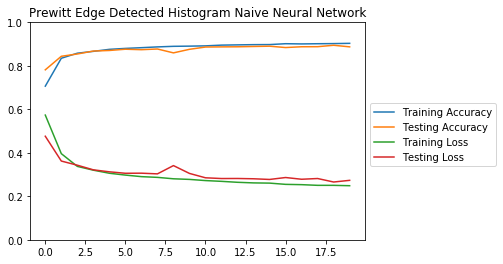

Total elapsed time:  0:00:24.446522


In [25]:
# Training accuracy
plt.plot(history_greyscale.history['acc'], label='Training Accuracy')

# Testing accuracy
plt.plot(history_greyscale.history['val_acc'], label='Testing Accuracy')

# Training loss
plt.plot(history_greyscale.history['loss'], label='Training Loss') 

# Testing loss
plt.plot(history_greyscale.history['val_loss'], label='Testing Loss')

# Add legend to outside of plot
plt.legend(bbox_to_anchor=(1, .65), loc='upper left', ncol=1)

# Set the title and y-axis limits
plt.title('Prewitt Edge Detected Histogram Naive Neural Network')
plt.ylim(0,1)

# Display the plot
plt.show()

# Print execution time 
print("Total elapsed time: ", time_out - time_in)

### The following model is a multi-layer CNN which looks at the raw image data RGB format

<t>This is by far the most computationally complex model. The basis for this model came from the most popular kernel on Kaggle. That particular model had a total of four 2d convolutional layers, and four fully connected layers. That model took about an hour and a half to run on my machine, so I decided to simplify it. The results after the simplification were 2% lower accuracy, but took a fraction of the time to run. The simplified model ended up with 2 convolutional layers (each followed by an activation and a maxpool layer), and two fully-connected layers. The first fully connected layer has 512 nodes, and the final layer is a single node followed by a sigmoid activation for classification. 
<br>
<t>The compilation utilized the same optimizers and loss function. 

#### Normalize the data

In [27]:
# Normalize the data between 0 and 1
data2 = np.array(data2) / 255

#### Split into train/validate

In [31]:
# Split the data into train/test
(train_X, test_X, train_Y, test_mY) = \
    train_test_split(data2, labels, test_size=.25, random_state=99)

# Parse into np.arrays
train_X = np.array(train_X)
test_X = np.array(test_X)

#### Reshape for CNN

In [33]:
# Reshape to appropriate shape for modeling
train_X = train_X.reshape(len(train_X), 64, 64, 3)
test_X = test_X.reshape(len(test_X), 64, 64, 3)

#### Compile model

In [34]:
# Declare the model 
model2 = Sequential()

# First 2d Conv layer and activation
model2.add(Conv2D(32, kernel_size=3,
                 padding = 'same',
                 input_shape=(64,64,3)))
model2.add(Activation('relu'))

# Pool to reduce dimentsionality
model2.add(MaxPooling2D(pool_size=2))

# Second 2d Conv layer and activation
model2.add(Conv2D(64, kernel_size=3, 
                padding = 'same'))
model2.add(Activation('relu'))

# Pooling Layer to reduce dimensionality
model2.add(MaxPooling2D(pool_size=2))

# Flatten for the fully connected layer
model2.add(Flatten())

# Add a fully connected layer and activation
model2.add(Dense(512))
model2.add(Activation('relu'))

# Add the final fully connected layer and 
# activate with softmax
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

In [35]:
# Start time
time_in = datetime.now()

# Compile the model with binary cross-entropy loss, Adam optimizers, and accuracy
# as the target metric
model2.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=0.0001), 
              metrics=["accuracy"])

# Run the model and append the metrics to a variable for plotting
history2 = model2.fit(train_X, train_Y, 
          validation_data=(test_X, test_Y), epochs=10, batch_size=32)

# End time
time_out = datetime.now()

Train on 20668 samples, validate on 6890 samples
Epoch 1/10
20668/20668 [==============================] - 121s 6ms/step - loss: 0.5792 - acc: 0.6979 - val_loss: 0.5333 - val_acc: 0.7208
Epoch 2/10
20668/20668 [==============================] - 137s 7ms/step - loss: 0.4673 - acc: 0.7810 - val_loss: 0.4094 - val_acc: 0.8234
Epoch 3/10
20668/20668 [==============================] - 122s 6ms/step - loss: 0.3442 - acc: 0.8596 - val_loss: 0.3581 - val_acc: 0.8286
Epoch 4/10
20668/20668 [==============================] - 118s 6ms/step - loss: 0.2470 - acc: 0.9073 - val_loss: 0.2437 - val_acc: 0.9035
Epoch 5/10
20668/20668 [==============================] - 120s 6ms/step - loss: 0.2005 - acc: 0.9255 - val_loss: 0.2191 - val_acc: 0.9226
Epoch 6/10
20668/20668 [==============================] - 119s 6ms/step - loss: 0.1736 - acc: 0.9372 - val_loss: 0.2141 - val_acc: 0.9202
Epoch 7/10
20668/20668 [==============================] - 118s 6ms/step - loss: 0.1543 - acc: 0.9444 - val_loss: 0.1944 - v

### Show the plot for accuracy and loss, print the execution time 

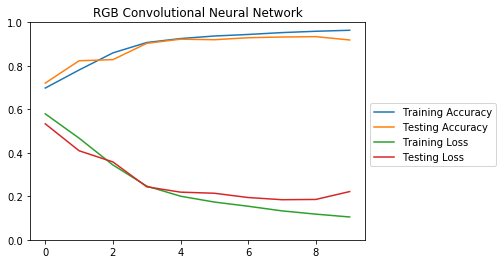

Elapsed Time:  0:20:13.377564


In [36]:
# Training Accuracy
plt.plot(history2.history['acc'], label='Training Accuracy')

# Testing Accuracy
plt.plot(history2.history['val_acc'], label='Testing Accuracy')

# Training loss
plt.plot(history2.history['loss'], label='Training Loss') 

# Testing loss
plt.plot(history2.history['val_loss'], label='Testing Loss')

# Add a legend to the outside of the plot
plt.legend(bbox_to_anchor=(1, .65), loc='upper left', ncol=1)

# Set the title and y-axis limits
plt.title('RGB Convolutional Neural Network')
plt.ylim(0,1)

# Display the plot
plt.show()

# Print the execution time 
print("Elapsed Time: ", time_out - time_in)

### 7. Conclusions

<t>In the end, my project ended up being about less about trying to create effective models, and more about choosing a model which had the greatest efficiency. In the end I was able to create a model (three color histogram) with comparable results, however this model uses far few computational resources. This shows the not only the importance of pre-processing, but also the performance potential that one can extract from a model through feature engineering. <br>
<br>
<t>Given the opporunity to continue my work on this dataset there are a few things which I would do. My first step would be a continuation of data pre-processing; the next step I would take is to apply PCA to the three color histogram to work further the dimension reductions. Another facet of continuing work on this model would be in model-tuning. The model works pretty well as is, but there is strong possibility that using a deeper model could lead to slightly better performance.<br>
<br>
<t>Also, when tuning the model, I would seek to alter the threshold (by lowering it) in the final sigmoid activation to mitigate false negatives. Typically in medical diagnosis models, it is a best practice to tune your model to recall instead of accuracy. It is often acceptable to acheive a false positive, as there is additional testing/screening before treatment. However, you want to avoid false negatives at all costs, because that is the equivalent of telling someone they're healthy and sending them home when they actually have a disease. <br>